### 라이브러리 로드

In [1]:
import sys
import os, os.path
from multiprocessing import Process, Queue, cpu_count
import cv2
import numpy as np
from PIL import Image

### 환경변수 설정

In [2]:
TILE_SIZE      = 50		# 타일 1개의 크기를 50x50으로 변환
TILE_MATCH_RES = 5		# tile matching resolution (higher values give better fit but require more processing)
ENLARGEMENT    = 8		# the mosaic image will be this many times wider and taller than the original

TILE_BLOCK_SIZE = TILE_SIZE / max(min(TILE_MATCH_RES, TILE_SIZE), 1)
WORKER_COUNT = max(cpu_count() - 1, 1)
OUT_FILE = 'mosaic_ipynb_cv2.jpeg'
EOQ_VALUE = None


img_path = ('target.jpg')
tiles_path = ('/home/jasper/dev/cv_project/test/source')

### TileProcessor

In [3]:
class TileProcessor:
	def __init__(self, tiles_directory):
		self.tiles_directory = tiles_directory

	def __process_tile(self, tile_path):
		try:		
			# OpenCV 라이브러리 사용하는 것으로 변경
			img = cv2.imread(tile_path)
			h, w = img.shape[:2]
			min_dimension = int(min(w, h))
			w_crop = int((w - min_dimension) / 2)
			h_crop = int((h - min_dimension) / 2)
			# print(f'h: {h}, w: {w}, min: {min_dimension}, w_c: {w_crop}, h_c: {h_crop}')

			img = img[h_crop : h - h_crop, w_crop : w - w_crop] # opencv

			large_tile_img = cv2.resize(img, (TILE_SIZE, TILE_SIZE), interpolation=cv2.INTER_NEAREST)
			small_tile_img = cv2.resize(img, (int(TILE_SIZE/TILE_BLOCK_SIZE), int(TILE_SIZE/TILE_BLOCK_SIZE)), interpolation=cv2.INTER_NEAREST)
			
			large_tile_img = cv2.cvtColor(large_tile_img, cv2.COLOR_BGR2RGB)
			small_tile_img = cv2.cvtColor(small_tile_img, cv2.COLOR_BGR2RGB)


			# 결국 Pil 라이브러리르 사용해야함
			large_tile_img=Image.fromarray(large_tile_img)
			small_tile_img=Image.fromarray(small_tile_img)
			return (large_tile_img, small_tile_img)
		
		except:
			return (None, None)			

	def get_tiles(self):
		large_tiles = []
		small_tiles = []

		print('Reading tiles from {}...'.format(self.tiles_directory))

		# search the tiles directory recursively
		for root, subFolders, files in os.walk(self.tiles_directory):
			for tile_name in files:
				print('Reading {:40.40}'.format(tile_name), flush=True, end='\r')
				tile_path = os.path.join(root, tile_name)
				large_tile, small_tile = self.__process_tile(tile_path)
				if large_tile is not None:
					large_tiles.append(large_tile)
					small_tiles.append(small_tile)


		print('Processed {} tiles.'.format(len(large_tiles)))

		return (large_tiles, small_tiles)

### TargetImage

In [4]:
class TargetImage:
	def __init__(self, image_path):
		self.image_path = image_path

	def get_data(self):
		print('Processing main image...')
		img = cv2.imread(self.image_path)
		h, w = img.shape[:2]
		h *= ENLARGEMENT
		w *= ENLARGEMENT

		large_img = cv2.resize(img, (w, h), interpolation=cv2.INTER_NEAREST)

		w_diff = int((w % TILE_SIZE)/2)
		h_diff = int((h % TILE_SIZE)/2)
		
		# if necessary, crop the image slightly so we use a whole number of tiles horizontally and vertically
		if w_diff or h_diff:
			large_img = large_img[h_diff : h - h_diff, w_diff : w - w_diff] # opencv
		small_img = cv2.resize(large_img, (int(w/TILE_BLOCK_SIZE), int(h/TILE_BLOCK_SIZE)), interpolation=cv2.INTER_NEAREST)

		large_img = cv2.cvtColor(large_img, cv2.COLOR_BGR2RGB)
		small_img = cv2.cvtColor(small_img, cv2.COLOR_BGR2RGB)

		# 결국 Pil 라이브러리르 사용해야함
		large_img=Image.fromarray(large_img)
		small_img=Image.fromarray(small_img)


		image_data = (large_img, small_img)

		print('Main image processed.')

		return image_data

### TileFilter

In [5]:
class TileFitter:
	def __init__(self, tiles_data):
		self.tiles_data = tiles_data

	def __get_tile_diff(self, t1, t2, bail_out_value):
		diff = 0
		for i in range(len(t1)):
			#diff += (abs(t1[i][0] - t2[i][0]) + abs(t1[i][1] - t2[i][1]) + abs(t1[i][2] - t2[i][2]))
			diff += ((t1[i][0] - t2[i][0])**2 + (t1[i][1] - t2[i][1])**2 + (t1[i][2] - t2[i][2])**2)
			if diff > bail_out_value:
				# we know already that this isn't going to be the best fit, so no point continuing with this tile
				return diff
		return diff

	def get_best_fit_tile(self, img_data):
		best_fit_tile_index = None
		min_diff = sys.maxsize
		tile_index = 0

		# go through each tile in turn looking for the best match for the part of the image represented by 'img_data'
		for tile_data in self.tiles_data:
			diff = self.__get_tile_diff(img_data, tile_data, min_diff)
			if diff < min_diff:
				min_diff = diff
				best_fit_tile_index = tile_index
			tile_index += 1

		return best_fit_tile_index

### fit_tiles

In [6]:
def fit_tiles(work_queue, result_queue, tiles_data):
	# this function gets run by the worker processes, one on each CPU core
	tile_fitter = TileFitter(tiles_data)

	while True:
		try:
			img_data, img_coords = work_queue.get(True)
			if img_data == EOQ_VALUE:
				break
			tile_index = tile_fitter.get_best_fit_tile(img_data)
			result_queue.put((img_coords, tile_index))
		except KeyboardInterrupt:
			pass

	# let the result handler know that this worker has finished everything
	result_queue.put((EOQ_VALUE, EOQ_VALUE))

### ProgressCounter

In [7]:
class ProgressCounter:
	def __init__(self, total):
		self.total = total
		self.counter = 0

	def update(self):
		self.counter += 1
		print("Progress: {:04.1f}%".format(100 * self.counter / self.total), flush=True, end='\r')

### MosaicImage

In [8]:
class MosaicImage:
	def __init__(self, original_img):
		# Image.new 메소드가 cv2에는 없는것으로 생각됨.. mode = 'rgb
		self.image = Image.new(original_img.mode, original_img.size)
		self.x_tile_count = int(original_img.size[0] / TILE_SIZE)
		self.y_tile_count = int(original_img.size[1] / TILE_SIZE)
		self.total_tiles  = self.x_tile_count * self.y_tile_count

	def add_tile(self, tile_data, coords):
		img = Image.new('RGB', (TILE_SIZE, TILE_SIZE))
		img.putdata(tile_data)
		self.image.paste(img, coords)

	def save(self, path):
		self.image.save(path)

### build_mosaic

In [9]:
def build_mosaic(result_queue, all_tile_data_large, original_img_large):
	mosaic = MosaicImage(original_img_large)

	active_workers = WORKER_COUNT
	while True:
		try:
			img_coords, best_fit_tile_index = result_queue.get()

			if img_coords == EOQ_VALUE:
				active_workers -= 1
				if not active_workers:
					break
			else:
				tile_data = all_tile_data_large[best_fit_tile_index]
				mosaic.add_tile(tile_data, img_coords)

		except KeyboardInterrupt:
			pass

	mosaic.save(OUT_FILE)
	print('\nFinished, output is in', OUT_FILE)

### compose

In [10]:
def compose(original_img, tiles):
	print('Building mosaic, press Ctrl-C to abort...')
	original_img_large, original_img_small = original_img
	tiles_large, tiles_small = tiles

	mosaic = MosaicImage(original_img_large)

	all_tile_data_large = [list(tile.getdata()) for tile in tiles_large]
	all_tile_data_small = [list(tile.getdata()) for tile in tiles_small]

	work_queue   = Queue(WORKER_COUNT)	
	result_queue = Queue()

	try:
		# start the worker processes that will build the mosaic image
		Process(target=build_mosaic, args=(result_queue, all_tile_data_large, original_img_large)).start()

		# start the worker processes that will perform the tile fitting
		for n in range(WORKER_COUNT):
			Process(target=fit_tiles, args=(work_queue, result_queue, all_tile_data_small)).start()

		progress = ProgressCounter(mosaic.x_tile_count * mosaic.y_tile_count)
		for x in range(mosaic.x_tile_count):
			for y in range(mosaic.y_tile_count):
				large_box = (x * TILE_SIZE, y * TILE_SIZE, (x + 1) * TILE_SIZE, (y + 1) * TILE_SIZE)
				small_box = (x * TILE_SIZE/TILE_BLOCK_SIZE, y * TILE_SIZE/TILE_BLOCK_SIZE, (x + 1) * TILE_SIZE/TILE_BLOCK_SIZE, (y + 1) * TILE_SIZE/TILE_BLOCK_SIZE)
				work_queue.put((list(original_img_small.crop(small_box).getdata()), large_box))
				progress.update()

	except KeyboardInterrupt:
		print('\nHalting, saving partial image please wait...')

	finally:
		# put these special values onto the queue to let the workers know they can terminate
		for n in range(WORKER_COUNT):
			work_queue.put((EOQ_VALUE, EOQ_VALUE))

#### show_error

In [11]:
def show_error(msg):
	print('ERROR: {}'.format(msg))

In [12]:
def mosaic(img_path, tiles_path):
	image_data = TargetImage(img_path).get_data()
	tiles_data = TileProcessor(tiles_path).get_tiles()
	print(tiles_data)
	if tiles_data[0]:
		compose(image_data, tiles_data)
	else:
		show_error("No images found in tiles directory '{}'".format(tiles_path))

if __name__ == '__main__':
	if len(sys.argv) < 3:
		show_error('Usage: {} <image> <tiles directory>\r'.format(sys.argv[0]))
	else:
		# source_image = sys.argv[1]
		# tile_dir = sys.argv[2]
		source_image = img_path
		tile_dir = tiles_path
		if not os.path.isfile(source_image):
			show_error("Unable to find image file '{}'".format(source_image))
		elif not os.path.isdir(tile_dir):
			show_error("Unable to find tile directory '{}'".format(tile_dir))
		else:
			mosaic(source_image, tile_dir)

Processing main image...
Main image processed.
Reading tiles from /home/jasper/dev/cv_project/test/source...
Processed 821 tiles.                            
([<PIL.Image.Image image mode=RGB size=50x50 at 0x7F72496BA4A0>, <PIL.Image.Image image mode=RGB size=50x50 at 0x7F7248CAE500>, <PIL.Image.Image image mode=RGB size=50x50 at 0x7F7248CAF460>, <PIL.Image.Image image mode=RGB size=50x50 at 0x7F7249785E70>, <PIL.Image.Image image mode=RGB size=50x50 at 0x7F7248E15240>, <PIL.Image.Image image mode=RGB size=50x50 at 0x7F7248E15840>, <PIL.Image.Image image mode=RGB size=50x50 at 0x7F72494976A0>, <PIL.Image.Image image mode=RGB size=50x50 at 0x7F720C94BC10>, <PIL.Image.Image image mode=RGB size=50x50 at 0x7F720C94BC40>, <PIL.Image.Image image mode=RGB size=50x50 at 0x7F720C94A6B0>, <PIL.Image.Image image mode=RGB size=50x50 at 0x7F720C94A050>, <PIL.Image.Image image mode=RGB size=50x50 at 0x7F720C949570>, <PIL.Image.Image image mode=RGB size=50x50 at 0x7F720C949F60>, <PIL.Image.Image imag


Finished, output is in mosaic_ipynb_cv2.jpeg


In [14]:
target = cv2.imread('./target.jpg')
img = cv2.imread('./mosaic(821).jpeg', cv2.IMREAD_REDUCED_COLOR_8)

cv2.imshow('target', target)
cv2.imshow('img', img)
cv2.waitKey()
cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x11aba10) is not the object's thread (0x1a9e2d0).
Cannot move to target thread (0x11aba10)

QObject::moveToThread: Current thread (0x11aba10) is not the object's thread (0x1a9e2d0).
Cannot move to target thread (0x11aba10)

QObject::moveToThread: Current thread (0x11aba10) is not the object's thread (0x1a9e2d0).
Cannot move to target thread (0x11aba10)

QObject::moveToThread: Current thread (0x11aba10) is not the object's thread (0x1a9e2d0).
Cannot move to target thread (0x11aba10)

QObject::moveToThread: Current thread (0x11aba10) is not the object's thread (0x1a9e2d0).
Cannot move to target thread (0x11aba10)

QObject::moveToThread: Current thread (0x11aba10) is not the object's thread (0x1a9e2d0).
Cannot move to target thread (0x11aba10)

QObject::moveToThread: Current thread (0x11aba10) is not the object's thread (0x1a9e2d0).
Cannot move to target thread (0x11aba10)

QObject::moveToThread: Current thread (0x11aba10) is not the object's thread

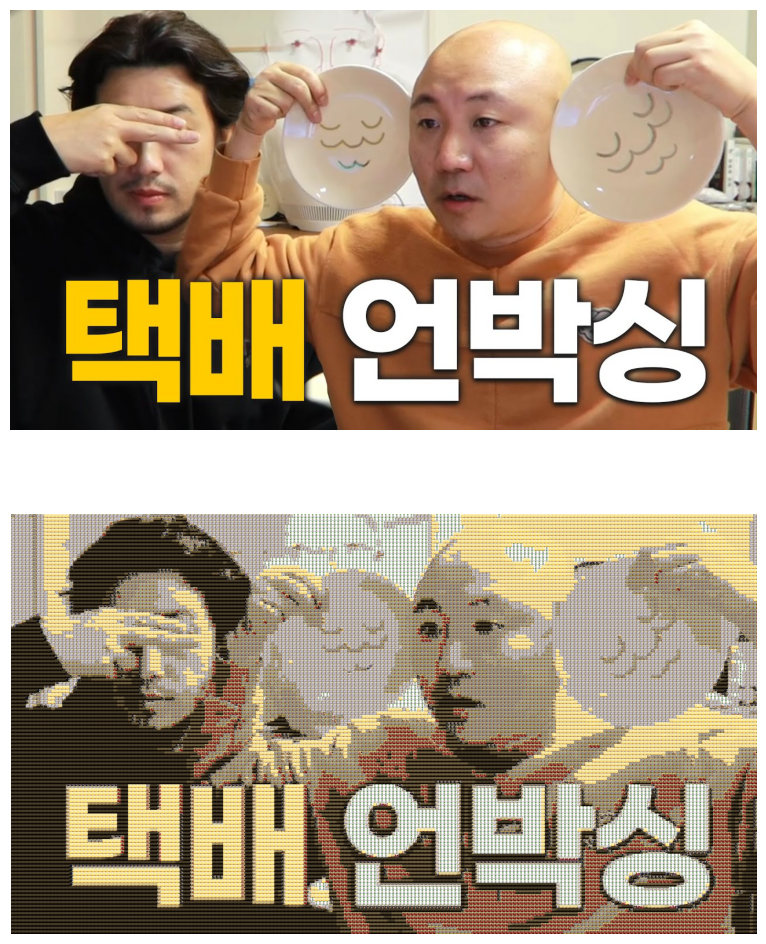

In [22]:
import matplotlib.pyplot as plt
target = plt.imread('./target.jpg')
img = plt.imread('./mosaic(821).jpeg')

plt.figure(figsize=(20, 12))

plt.subplot(2, 1, 1)
plt.imshow(target)
plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(img)
plt.axis('off')
plt.show()